In [1108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from nltk.corpus import stopwords
import nltk
import joblib

In [1109]:
df = pd.read_csv("text_phishing_es_new.csv")
df

,Email Text,Email Type,Email Text Spanish
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,"Re: 6. 1100, disco: uniformitarismo, Re: 1086;..."
1,the other side of * galicismos * * galicismo *...,Safe Email,El otro lado de * Galicicho * * Galicismo * es...
2,re : equistar deal tickets are you still avail...,Safe Email,Re: Tickets de acuerdo de Equistar todavía est...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,"Hola, soy tu juguete caliente y caliente.\n ..."
4,software at incredibly low prices ( 86 % lower...,Phishing Email,Software a precios increíblemente bajos (86 % ...
...,...,...,...
6526,please respond banque international du burkina...,Phishing Email,"Responda la banca internacional du burkina, av..."
6527,new books : syntax new from holland academic g...,Safe Email,Nuevos libros: Sintaxis Nuevo de Holland Acade...
6528,fw : no truer words were ever spoken cute ! - ...,Safe Email,FW: ¡Alguna vez no se pronunciaron palabras má...
6529,">>>>> ""G"" == Gregory Alan Bolcer writes: G...",Safe Email,">>>>> ""G"" == Gregory Alan Bolcer escribe: G> E..."


In [1110]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6531 entries, 0 to 6530
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Email Text          6520 non-null   object
 1   Email Type          6531 non-null   object
 2   Email Text Spanish  6531 non-null   object
dtypes: object(3)
memory usage: 153.2+ KB
None


In [1111]:
df.isnull().sum()

Email Text            11
Email Type             0
Email Text Spanish     0
dtype: int64

In [1112]:
df["Email Type"].value_counts()

Email Type
Safe Email        3958
Phishing Email    2573
Name: count, dtype: int64

In [1113]:
df.duplicated().sum()

np.int64(280)

In [1114]:
# Eliminar filas con texto vacío o nulo
df = df.dropna()
df.isnull().sum()

Email Text            0
Email Type            0
Email Text Spanish    0
dtype: int64

In [1115]:
#Se pasa las columnas a la nomenclatura snake_case
df = df.rename(columns={'Email Text': 'email_text', 'Email Type': 'email_type'})

In [1116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6520 entries, 0 to 6530
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   email_text          6520 non-null   object
 1   email_type          6520 non-null   object
 2   Email Text Spanish  6520 non-null   object
dtypes: object(3)
memory usage: 203.8+ KB


In [1117]:
# Añadir una columna Label, mapear los valores de Email Type para convertirlos a numéricos
df['label'] = df['email_type'].map({'Phishing Email': 1, 'Safe Email': 0})

In [1118]:
df = df.drop(columns=['email_type'])

In [1119]:
df['email_length'] = df['email_text'].apply(len)

In [1120]:
df.describe()

,label,email_length
count,6520.000000,6520.000000
mean,0.392945,1124.069785
std,0.488442,1029.290559
min,0.000000,5.000000
25%,0.000000,376.000000
50%,0.000000,785.000000
75%,1.000000,1557.000000
max,1.000000,4998.000000


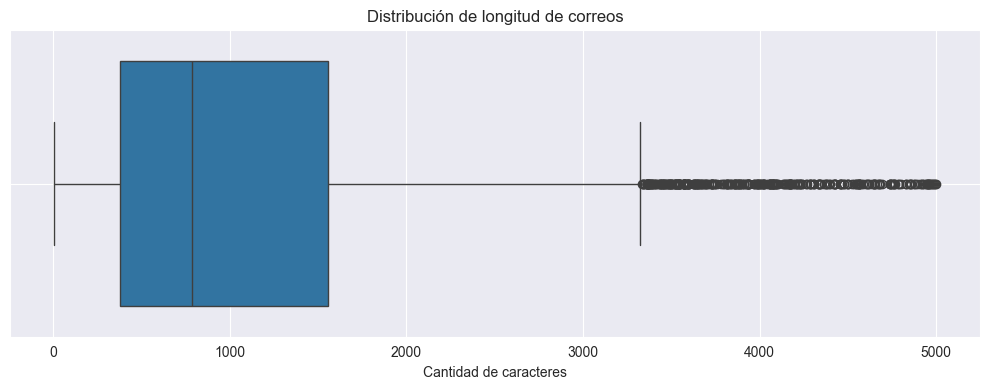

In [1121]:
# Visualizar distribución de longitudes
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='email_length')
plt.title("Distribución de longitud de correos")
plt.xlabel("Cantidad de caracteres")
plt.grid(True) # Mostrar la grilla del fondo
plt.tight_layout() # Ajusta automáticamente el gráfico para que no se corte
plt.show()

In [1122]:
df['email_length'].sort_values(ascending=False)

5198    4998
4876    4992
5652    4989
3683    4980
5290    4975
        ... 
6077       5
3642       5
1864       5
3636       5
4881       5
Name: email_length, Length: 6520, dtype: int64

In [1123]:
# Escalar longitud del correo
scaler = StandardScaler()
df['email_length_scaled'] = scaler.fit_transform(df[['email_length']])

In [1124]:
df

,email_text,Email Text Spanish,label,email_length,email_length_scaled
0,"re : 6 . 1100 , disc : uniformitarianism , re ...","Re: 6. 1100, disco: uniformitarismo, Re: 1086;...",0,1030,-0.091400
1,the other side of * galicismos * * galicismo *...,El otro lado de * Galicicho * * Galicismo * es...,0,479,-0.626761
2,re : equistar deal tickets are you still avail...,Re: Tickets de acuerdo de Equistar todavía est...,0,1245,0.117498
3,\nHello I am your hot lil horny toy.\n I am...,"Hola, soy tu juguete caliente y caliente.\n ...",1,688,-0.423693
4,software at incredibly low prices ( 86 % lower...,Software a precios increíblemente bajos (86 % ...,1,441,-0.663683
...,...,...,...,...,...
6526,please respond banque international du burkina...,"Responda la banca internacional du burkina, av...",1,3151,1.969401
6527,new books : syntax new from holland academic g...,Nuevos libros: Sintaxis Nuevo de Holland Acade...,0,1813,0.669377
6528,fw : no truer words were ever spoken cute ! - ...,FW: ¡Alguna vez no se pronunciaron palabras má...,0,1247,0.119441
6529,">>>>> ""G"" == Gregory Alan Bolcer writes: G...",">>>>> ""G"" == Gregory Alan Bolcer escribe: G> E...",0,2309,1.151299


In [1125]:
df=df.drop("email_text", axis=1)
#Se pasa las columnas a la nomenclatura snake_case
df = df.rename(columns={'Email Text Spanish': 'email_text'})

In [1126]:
# 5. Preparar datos para ML
X_text = df['email_text']  # features: cuerpo del email
X_num = df[['email_length_scaled']]
y = df['label']       # etiquetas: 1 = phishing, 0 = legítimo

In [1127]:
# Dividir en entrenamiento y prueba
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, stratify=y, random_state=42
)

In [1128]:
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to C:\Users\Daniel
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1129]:
# Convertimos texto a vectores numéricos con TF-IDF
tfidf_body = TfidfVectorizer(stop_words=spanish_stopwords, max_features=10000)
X_train_tfidf = tfidf_body.fit_transform(X_train_text)
X_test_tfidf = tfidf_body.transform(X_test_text)

In [1130]:
# Unir vectores TF-IDF + numéricos normalizados
X_train_final = hstack([X_train_tfidf, X_train_num])
X_test_final = hstack([X_test_tfidf, X_test_num])

In [1131]:
# 1. Definir el modelo base
log_reg = LogisticRegression(random_state=42)

# 2. Definir los hiperparámetros a probar
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300, 500]
}

# 3. Aplicar búsqueda de hiperparámetros con validación cruzada
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# 4. Entrenar el modelo con el mejor conjunto de hiperparámetros
grid.fit(X_train_final, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'max_iter': [100, 200, 300, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='f1', verbose=1)

In [1132]:
# Predicciones
y_pred = grid.predict(X_test_final)

# Reporte
print("\n Mejores parámetros encontrados:", grid.best_params_)
print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=["Safe", "Phishing"]))
print("\n Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))


 Mejores parámetros encontrados: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

 Reporte de Clasificación:
               precision    recall  f1-score   support

        Safe       0.98      0.97      0.97       792
    Phishing       0.95      0.97      0.96       512

    accuracy                           0.97      1304
   macro avg       0.96      0.97      0.97      1304
weighted avg       0.97      0.97      0.97      1304


 Matriz de Confusión:
 [[766  26]
 [ 17 495]]


In [1133]:
print("Mejor configuración:", grid.best_params_)
print("Mejor F1 Score CV:", grid.best_score_)

Mejor configuración: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1 Score CV: 0.9532342048597764


In [1134]:
# Entrenamos una regresión logística
model_body = LogisticRegression(
    C=10,
    max_iter=100,
    penalty='l2',
    solver='liblinear',
    random_state=42
)
model_body.fit(X_train_final, y_train)

LogisticRegression(C=10, random_state=42, solver='liblinear')

In [1135]:
# 8. Evaluación del modelo
# Predicciones
y_pred_final = model_body.predict(X_test_final)

In [1136]:
# Probabilidades y predicciones
y_proba = grid.best_estimator_.predict_proba(X_test_final)[:, 1]
y_pred = grid.best_estimator_.predict(X_test_final)

# Métricas
print("=== Resultados del Modelo en Cuerpo de Correos ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

=== Resultados del Modelo en Cuerpo de Correos ===
Accuracy:  0.9670
Precision: 0.9501
Recall:    0.9668
F1 Score:  0.9584
ROC AUC:   0.9951


In [1137]:
# Matriz de confusión
print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


🧮 Matriz de confusión:
[[766  26]
 [ 17 495]]


In [1138]:
print(classification_report(y_test, y_pred, target_names=["Safe", "Phishing"]))

              precision    recall  f1-score   support

        Safe       0.98      0.97      0.97       792
    Phishing       0.95      0.97      0.96       512

    accuracy                           0.97      1304
   macro avg       0.96      0.97      0.97      1304
weighted avg       0.97      0.97      0.97      1304



In [1139]:
joblib.dump(grid.best_estimator_, "model_body_es.pkl")
joblib.dump(tfidf_body, "tfidf_body_es.pkl")
joblib.dump(scaler, "scaler_es.pkl")

print("Exported model")
print("Exported tfidf_body")
print("Exported scaler")

Exported model
Exported tfidf_body
Exported scaler


In [1140]:
model = joblib.load("model_body_es.pkl")
print("⛳️ Número de columnas que espera el modelo:", model.n_features_in_)

⛳️ Número de columnas que espera el modelo: 10001
